# Week 2

### Exercise:
Use and experience methods from previous lessons with given data. Try to search for other pandas methods to analyze the data such as groupby() and read_csv().

In [105]:
# You can find covid related data under project's data folder 
# base_url = "../data/covid/"
# infected_dataset_url = base_url + "time_series_covid19_confirmed_global.csv"
# recovered_dataset_url = base_url + "time_series_covid19_recovered_global.csv"
# deaths_dataset_url = base_url + "time_series_covid19_deaths_global.csv"

Latitude: Indicates the position of a place in the northern or southern hemispheres. Latitudes are measured as the angular distance between the equator and the North Pole or South Pole. Positive values are in the northern hemisphere and negative values are in the southern hemisphere.

Longitude: Indicates the position of a place in the eastern or western hemispheres. Longitude is measured as the angular distance between a place and the meridian at Greenwich (England). Positive values are in the eastern hemisphere and negative values are in the western hemisphere.

### Solution:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 500)

In [2]:
def merge_and_cleanup(df):
    if 'Province/State' in df.columns:
        df = df.drop(columns=['Lat', 'Long'])
        grouped_df = df.groupby(['Country/Region'], as_index=False).sum()
        
        if 'Province/State' in grouped_df.columns:
            grouped_df = grouped_df.drop(columns=['Province/State'])
    else:
        grouped_df = df.drop(columns=['Lat', 'Long']).copy()

    return grouped_df

In [3]:
infected = pd.read_csv("time_series_covid19_confirmed_global.csv")
recovered = pd.read_csv("time_series_covid19_recovered_global.csv")
deaths = pd.read_csv("time_series_covid19_deaths_global.csv")
population = pd.read_csv("population2020.csv")

In [4]:
infected_merged = merge_and_cleanup(infected)
recovered_merged = merge_and_cleanup(recovered)
deaths_merged = merge_and_cleanup(deaths)

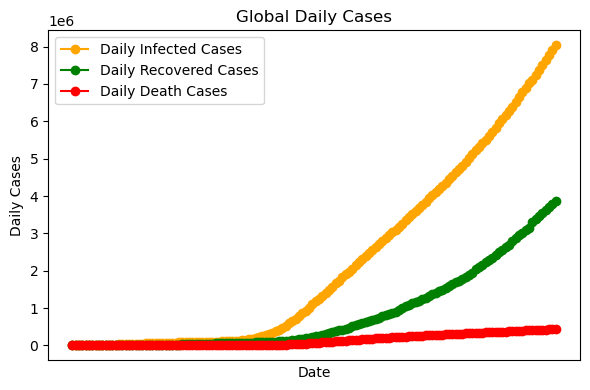

In [5]:
plt.figure(figsize=(6, 4))

# Infected graph
infected_daily = infected.drop(columns=['Lat', 'Long', 'Province/State', 'Country/Region']).sum()
plt.plot(infected_daily.index, infected_daily, label='Daily Infected Cases', marker='o', color='orange')

# Recovered graph
recovered_daily = recovered.drop(columns=['Lat', 'Long', 'Province/State', 'Country/Region']).sum()
plt.plot(recovered_daily.index, recovered_daily, label='Daily Recovered Cases', marker='o', color='green')

# Deaths graph
deaths_daily = deaths.drop(columns=['Lat', 'Long', 'Province/State', 'Country/Region']).sum()
plt.plot(deaths_daily.index, deaths_daily, label='Daily Death Cases', marker='o', color='red')

plt.xlabel('Date')
plt.ylabel('Daily Cases')
plt.title('Global Daily Cases')
plt.legend()

# Edit date format
date_format = DateFormatter('%m/%d')
plt.gca().xaxis.set_major_formatter(date_format)

# Remove X-axis labels
plt.xticks([])

plt.tight_layout()
plt.show()

In [6]:
def merge_to_weekly(df):
    date_columns = df.columns[1:-1]

    # Melt the DataFrame to convert date columns to rows
    melted = pd.melt(df, id_vars=['Country/Region'], value_vars=date_columns, var_name='Date', value_name='Cases')

    # Convert the 'Date' column to datetime format
    melted['Date'] = pd.to_datetime(melted['Date'], format='%m/%d/%y', errors='coerce')

    # Group weekly and get the total number of cases
    weekly_df = melted.groupby(['Country/Region', melted['Date'].dt.to_period("W-Mon")])['Cases'].sum().reset_index()
    
    return weekly_df

In [7]:
infected_weekly = merge_to_weekly(infected_merged)
recovered_weekly = merge_to_weekly(recovered_merged)
deaths_weekly = merge_to_weekly(deaths_merged)

In [8]:
df = pd.merge(infected_weekly, recovered_weekly, on=['Country/Region', 'Date'], how='outer', suffixes=('_infected', '_recovered')).merge(
    deaths_weekly, on=['Country/Region', 'Date'], how='outer', suffixes=('_recovered', '_deaths'))

In [9]:
df = df.rename(columns={
    'Cases_infected': 'infected_cases',
    'Cases_recovered': 'recovered_cases',})

df = df.rename(columns={'Cases': 'death_cases'})

population.columns = [col.lower() for col in population.columns]
df.columns = [col.lower() for col in df.columns]

population = population.rename(columns={'country (or dependency)': 'country/region', 'population (2020)': 'population'})

In [10]:
df = pd.merge(df, population[['country/region', 'population']], on='country/region', how='left')

In [15]:
df.tail()

,country/region,date,infected_cases,recovered_cases,death_cases,population
3943,Zimbabwe,2020-05-12/2020-05-18,284,95,28,14814609.000
3944,Zimbabwe,2020-05-19/2020-05-25,364,140,28,14814609.000
3945,Zimbabwe,2020-05-26/2020-06-01,1041,193,28,14814609.000
3946,Zimbabwe,2020-06-02/2020-06-08,1778,235,28,14814609.000
3947,Zimbabwe,2020-06-09/2020-06-15,2048,305,24,14814609.000


In [14]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
infected_cases,3948.000,80506.990,540640.178,0.000,0.000,358.500,9244.750,13309640.000
recovered_cases,3948.000,30093.720,163609.516,0.000,0.000,49.000,2446.000,3445572.000
death_cases,3948.000,5066.255,35177.715,0.000,0.000,7.000,188.000,763600.000
population,3633.000,41220954.416,153937377.118,801.000,2530535.000,9488821.000,29676420.000,1438116346.000


In [17]:
def show_top_countries(df, population_column, top_n=5, ascending=False):
    df_copy = df.copy()
    
    # Group by country and calculate sum of cases for each group
    grouped_df = df.groupby('country/region').agg({
        'infected_cases': 'sum',
        'recovered_cases': 'sum',
        'death_cases': 'sum',
        population_column: 'first'  # Take the population of the first entry in the group
    }).reset_index()

    # Calculate death, recovery, and infected ratios per 100,000 people
    grouped_df['death_ratio'] = (grouped_df['death_cases'] / grouped_df[population_column]) * 100
    grouped_df['recovery_ratio'] = (grouped_df['recovered_cases'] / grouped_df[population_column]) * 100
    grouped_df['infected_ratio'] = (grouped_df['infected_cases'] / grouped_df[population_column]) * 100

    # Sort the DataFrame by death ratio in ascending or descending order
    death_sorted = grouped_df.sort_values(by='death_ratio', ascending=ascending)
    recovery_sorted = grouped_df.sort_values(by='recovery_ratio', ascending=ascending)
    infected_sorted = grouped_df.sort_values(by='infected_ratio', ascending=ascending)

    # Select the top N countries
    top_death_countries = death_sorted.head(top_n)[['country/region', 'death_ratio']]
    top_recovery_countries = recovery_sorted.head(top_n)[['country/region', 'recovery_ratio']]
    top_infected_countries = infected_sorted.head(top_n)[['country/region', 'infected_ratio']]

    # Show the results using f-string
    print(f"Top {top_n} countries by Death Ratio:")
    for _, row in top_death_countries.iterrows():
        print(f"{row['country/region']} - Death Ratio: {row['death_ratio']:.2f}")

    print(f"\nTop {top_n} countries by Recovery Ratio:")
    for _, row in top_recovery_countries.iterrows():
        print(f"{row['country/region']} - Recovery Ratio: {row['recovery_ratio']:.2f}")

    print(f"\nTop {top_n} countries by Infected Ratio:")
    for _, row in top_infected_countries.iterrows():
        print(f"{row['country/region']} - Infected Ratio: {row['infected_ratio']:.2f}")


In [22]:
show_top_countries(df, 'population', top_n=10, ascending=False)

Top 10 countries by Death Ratio:
San Marino - Death Ratio: 9.67
Belgium - Death Ratio: 4.70
Andorra - Death Ratio: 4.13
Spain - Death Ratio: 3.89
Italy - Death Ratio: 3.65
United Kingdom - Death Ratio: 3.08
France - Death Ratio: 2.70
Sweden - Death Ratio: 2.15
Netherlands - Death Ratio: 2.09
Ireland - Death Ratio: 1.77

Top 10 countries by Recovery Ratio:
Andorra - Recovery Ratio: 44.92
San Marino - Recovery Ratio: 41.46
Iceland - Recovery Ratio: 33.02
Luxembourg - Recovery Ratio: 32.24
Qatar - Recovery Ratio: 30.37
Holy See - Recovery Ratio: 28.21
Ireland - Recovery Ratio: 20.28
Switzerland - Recovery Ratio: 19.54
Spain - Recovery Ratio: 18.45
Bahrain - Recovery Ratio: 15.62

Top 10 countries by Infected Ratio:
San Marino - Infected Ratio: 132.49
Holy See - Infected Ratio: 104.87
Qatar - Infected Ratio: 74.67
Andorra - Infected Ratio: 74.09
Luxembourg - Infected Ratio: 47.27
Iceland - Infected Ratio: 41.85
Spain - Infected Ratio: 35.22
Belgium - Infected Ratio: 31.10
Ireland - Infecte

In [23]:
show_top_countries(df, 'population', top_n=5, ascending=True)

Top 5 countries by Death Ratio:
Fiji - Death Ratio: 0.00
Seychelles - Death Ratio: 0.00
Papua New Guinea - Death Ratio: 0.00
Namibia - Death Ratio: 0.00
Cambodia - Death Ratio: 0.00

Top 5 countries by Recovery Ratio:
Sweden - Recovery Ratio: 0.00
Lesotho - Recovery Ratio: 0.00
Yemen - Recovery Ratio: 0.00
Angola - Recovery Ratio: 0.00
South Sudan - Recovery Ratio: 0.00

Top 5 countries by Infected Ratio:
Lesotho - Infected Ratio: 0.00
Papua New Guinea - Infected Ratio: 0.01
Angola - Infected Ratio: 0.01
Burundi - Infected Ratio: 0.02
Laos - Infected Ratio: 0.02
